In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [2]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Read data

In [3]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

overview = pd.DataFrame(
    [
        [len(data_et)],
        [len(data_trial)],
        [len(data_subject)]
    ], 
    columns=['length'],
    index=[
        'data_et', 
        'data_trial', 
        'data_subject'
          ]
)
print(overview)

              length
data_et       618566
data_trial     30362
data_subject      84


# Cleaning

## data_subject variables

In [4]:
data_subject['degree'] = data_subject['degree'].replace({'0': np.nan, '-3.0': np.nan})
data_subject['webcam_fps'] = np.round(data_subject['webcam_fps'])

## Enough trials?

In [5]:
NTrials = data_trial.groupby(['run_id'])['trial_index'].max() \
    .reset_index()
subjects_not_enough_trials = NTrials.loc[NTrials['trial_index']<400, 'run_id']
print('These subjects do not have enough trials: \n' + 
      str(NTrials.loc[NTrials['trial_index']<400, :])
     )

These subjects do not have enough trials: 
    run_id  trial_index
27      61        271.0
46     125         15.0
56    2002        112.0
59    2011         32.0


## Followed instructions? 

In [6]:
data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    ['run_id', 'prolificID', 'keptHead', 'triedChin']
]

,run_id,prolificID,keptHead,triedChin
5,12,5b8969006651ea000118e42e,1.0,0.0
29,48,5fa1192cf99e161a5cfad1cd,1.0,0.0
51,9,5fea6632bf9ae4a79153efdf,1.0,0.0
72,1003,0,1.0,0.0
74,1008,Ka61Kl61,1.0,0.0
81,2002,Tim2,0.0,0.0
82,2008,Studie1970,0.0,1.0


## filter

In [7]:
cleanSubjects = data_subject.loc[
        (data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC'])) &
        (data_subject['keptHead']!=0) &
        (data_subject['triedChin']!=0) &
        pd.notna(data_subject['fps']) &
        ~(data_subject['run_id'].isin(subjects_not_enough_trials)), 
        'run_id'
    ].unique()
cleanSubjects

array([   1,  103,   11,  126,  128,   13,  130,  131,   19,   24,   25,
         28,   30,   32,   36,   37,    4,   41,   42,   43,   45,   47,
          5,   58,   59,    6,   63,   66,   67,    7,   70,   74,   80,
         81,   85,   91,   92,   93,   94,   96,   97, 1000, 1011, 1021,
       2012, 2013, 2009], dtype=int64)

In [49]:
def cleanTrialData(data):
    print('raw data: ' + str(len(data)))
    data = data.loc[
        data['run_id'].isin(cleanSubjects), 
        :] \
    .reset_index(drop=True)
    print('cleaned data: ' + str(len(data)))
    return data

data_trial = cleanTrialData(data_trial)

raw data: 24234
cleaned data: 24234


In [9]:
def cleanETData(data, cleanSubjects):
    print('raw data: ' + str(len(data)))
    data = data.loc[
        (data['x']>0) & (data['x']<1) &(data['y']>0) & (data['y']<1) &
        (data['run_id'].isin(cleanSubjects)), :] \
        .reset_index(drop=True)
    print('cleaned data: ' + str(len(data)))
    return data

data_et = cleanETData(data_et, cleanSubjects)

data_et 
 raw: 618566
cleaned: 533061


# Position index

In [10]:
def addPositionIndex(data):
    data['positionIndex'] = 0

    x_pos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.35, 0.65, 0.35, 0.65]
    y_pos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8, 0.35, 0.35, 0.65, 0.65]

    for i in range(0, len(x_pos)):
        data.loc[(data['x_pos']==x_pos[i]) & (data['y_pos']==y_pos[i]), 'positionIndex']=i
    return data

data_trial = addPositionIndex(data_trial)

data_trial.loc[
    (data_trial['trial_type']=='eyetracking-calibration'), ['x_pos', 'y_pos', 'positionIndex']] \
    .drop_duplicates() \
    .sort_values(by='positionIndex')

,x_pos,y_pos,positionIndex
41,0.20,0.20,0
27,0.50,0.20,1
17,0.80,0.20,2
21,0.20,0.50,3
37,0.50,0.50,4
33,0.80,0.50,5
39,0.20,0.80,6
31,0.50,0.80,7
29,0.80,0.80,8
25,0.35,0.35,9


# data_et_fix, data_trial_fix

In [11]:
def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_et = add_var_to_data_et(data_et, data_trial, 'trial_type')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration')

data_et_fix = data_et.loc[
    (data_et['trial_type']=='eyetracking-fix-object') &
    (data_et['trial_duration']==5000) &
    (data_et['t_task']<1000),     :
]

data_trial_fix = data_trial.loc[
    (data_trial['trial_type']=='eyetracking-fix-object') &
    (data_trial['trial_duration']==5000),     :
].drop(columns=['trial_type', 'trial_duration'])

## Offset

### Calculate on gaze point-level

In [12]:
def euclideanDistance(x, x_target, y, y_target):
    x_diff = x - x_target
    y_diff = y - y_target
    euclideanDistance = np.sqrt(x_diff**2 + y_diff**2)
    return(euclideanDistance)

def offset(data):
    offset = euclideanDistance(
        data["x"], data['x_pos'],
        data["y"], data['y_pos'])
    return(offset)

data_et = add_var_to_data_et(data_et, data_trial, 'x_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'y_pos')
data_et_fix = add_var_to_data_et(data_et_fix, data_trial, 'x_pos')
data_et_fix = add_var_to_data_et(data_et_fix, data_trial, 'y_pos')

data_et.loc[:, "offset"] = offset(data_et)
data_et_fix.loc[:, "offset"] = offset(data_et_fix)

### Offset within trials

In [13]:
def select_fixTask_and_fixCross(data):
    return data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        ((data['task_nr']==1) |
            ((data['chinFirst']==0) & (data['task_nr']==2)) |
            ((data['chinFirst']==1) & (data['task_nr']==3))
        ), :]. reset_index(drop=True)

data_et = add_var_to_data_et(data_et, data_trial, 'task_nr')
data_et = add_var_to_data_et(data_et, data_trial, 'chin')
data_et = add_var_to_data_et(data_et, data_trial, 'chinFirst')

def reformatTTask(data):                                                 
    data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        (data['trial_duration']==1500), 
        't_task'
    ] = data.loc[
        (data['trial_type']=='eyetracking-fix-object') &
        (data['trial_duration']==1500), 
        't_task'
    ] - 1500
    return data

data_et = add_var_to_data_et(data_et, data_trial, 'trial_type')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration')
data_et_fix_task_fixCross = reformatTTask(select_fixTask_and_fixCross(data_et))

def add_next_xy_pos(data):
    data['next_x_pos']=0
    data['next_y_pos']=0
    for i in data.index:
        if data.loc[i, 'trial_duration']==1500:
            data.loc[i, 'next_x_pos'] = data.loc[i+1, 'x_pos']
            data.loc[i, 'next_y_pos'] = data.loc[i+1, 'y_pos']
    return(data)

data_trial_fix_task_fixCross = add_next_xy_pos(select_fixTask_and_fixCross(data_trial))

data_et_fix_task_fixCross = data_et_fix_task_fixCross.merge(
    data_trial_fix_task_fixCross.loc[:, ['run_id', 'trial_index', 'next_x_pos', 'next_y_pos']],
    on=['run_id', 'trial_index'],
    how='left'
)

In [14]:
def new_distance_for_fixCross(data):
    data.loc[data['trial_duration']==1500, 'offset'] = euclideanDistance(
        data.loc[data['trial_duration']==1500, 'x'], 
        data.loc[data['trial_duration']==1500, 'next_x_pos'], 
        data.loc[data['trial_duration']==1500, 'y'], 
        data.loc[data['trial_duration']==1500, 'next_y_pos']
    )
    return data
        
data_et_fix_task_fixCross = new_distance_for_fixCross(data_et_fix_task_fixCross)

In [15]:
def createAVGLine(data):
    binArray = np.arange(-1500, 5000, 50)
    bins = pd.cut(data['t_task'], binArray)
    output = data.groupby(bins).agg({"offset": "median"}).reset_index()
    output['t_task'] = binArray[0:len(output)]
    return output

average_line_noChin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==0, :])
average_line_chin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==1, :])

Text(0.5, 0, 't_task')

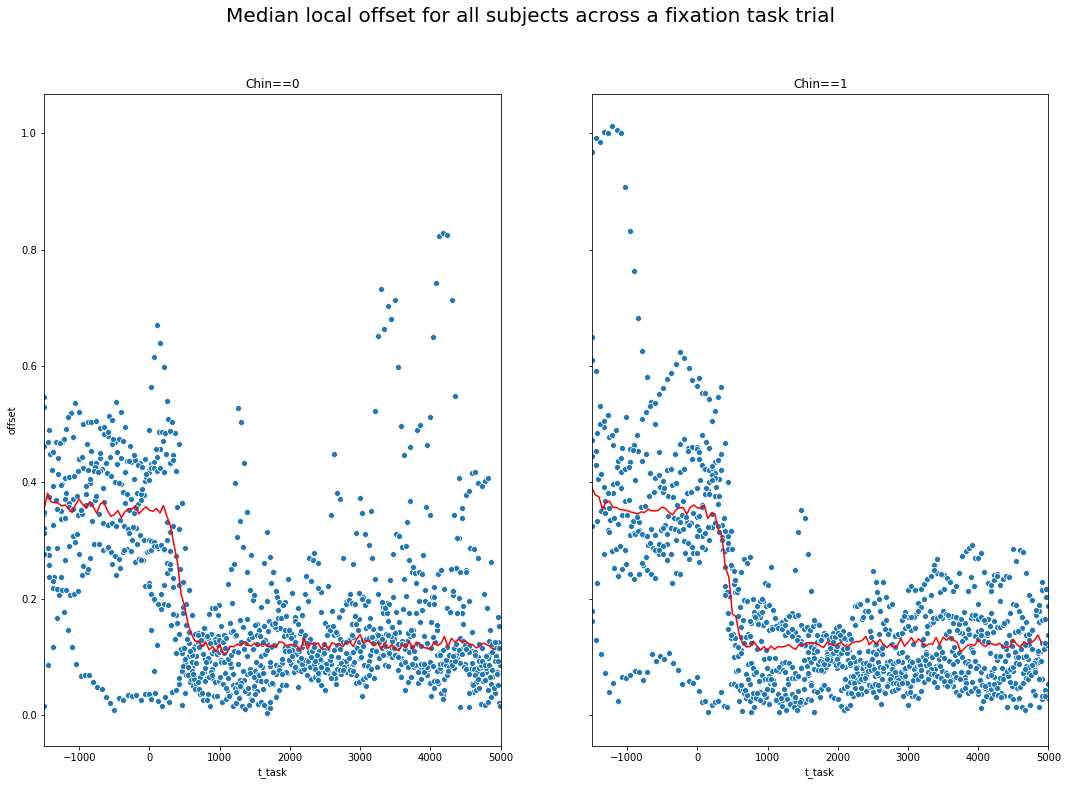

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 12))
fig.suptitle('Median local offset for all subjects across a fixation task trial', fontsize=20)

axes[0].set_title("Chin==0")
axes[1].set_title("Chin==1")

sns.scatterplot(ax=axes[0], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==0), 
                    :], 
                x="t_task", y="offset")
sns.lineplot(ax=axes[0], x=average_line_noChin['t_task'], y=average_line_noChin['offset'], color='r')

sns.scatterplot(ax=axes[1], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==1), 
                    :],
                x="t_task", y="offset")
sns.lineplot(ax=axes[1], x=average_line_chin['t_task'], y=average_line_chin['offset'], color='r')

plt.setp(axes, xlim=(-1500, 5000)) 
plt.xlabel("t_task")

### Aggregate on trial level

In [17]:
def merge_offset_by_index(data, data_et):
    if 'offset' in data.columns: 
        data = data.drop(columns=['offset'])
    grouped = data_et.groupby(['run_id', 'trial_index'])['offset'].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left')
    return data

data_trial = merge_offset_by_index(data_trial, data_et)
data_trial_fix = merge_offset_by_index(data_trial_fix, data_et_fix)

### Aggregate on subject-level 

In [18]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data

data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset')

def separate_outcomes_chin_condition(data, large_data, varName):
    var_chin_0 = varName + '_chin_0' 
    var_chin_1 = varName + '_chin_1' 
    
    if var_chin_0 in data.columns: data = data.drop(columns=[var_chin_0])
    if var_chin_1 in data.columns: data = data.drop(columns=[var_chin_1])
        
    grouped = large_data \
        .groupby(['run_id', 'chin'])[varName].mean() \
        .reset_index() \
        .pivot(index='run_id', columns='chin', values=varName) \
        .reset_index() \
        .rename(columns={0.0: var_chin_0, 1.0: var_chin_1}) 
    data = data.merge(grouped.loc[:, ['run_id', var_chin_0, var_chin_1]], on='run_id', how='left')
    return data

data_subject = separate_outcomes_chin_condition(data_subject, data_trial_fix, 'offset')
data_subject.loc[:, ['offset', 'offset_chin_0', 'offset_chin_1']].describe()

,offset,offset_chin_0,offset_chin_1
count,47.000000,46.000000,47.000000
mean,0.277851,0.272910,0.280409
std,0.080838,0.079291,0.090130
min,0.169163,0.170416,0.167910
25%,0.221046,0.220740,0.222282
50%,0.262391,0.258078,0.266352
75%,0.311943,0.306256,0.321454
max,0.595629,0.573215,0.640456


## Precision

### Distance from AVG on et-level

In [19]:
def merge_xy_means(data):    
    grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \
        .rename(columns={'x': 'x_mean', 'y': 'y_mean'})
    
    if 'x_mean' in data.columns: 
        data = data.drop(columns=['x_mean'])
    if 'y_mean' in data.columns: 
        data = data.drop(columns=['y_mean'])
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left') 
    
    return(data)

def distanceFromAVG_square(data):
    data = merge_xy_means(data)
    data['distanceFromAVG_square'] = np.power(
        euclideanDistance(data['x'], data['x_mean'], data['y'], data['y_mean']),
        2
    )
    
    return(data)  

data_et = distanceFromAVG_square(data_et)
data_et_fix = distanceFromAVG_square(data_et_fix)
data_et_fix.loc[
    pd.isna(data_et_fix['distanceFromAVG_square']), 
    ['x', 'y', 'x_pos', 'y_pos', 'distanceFromAVG_square']
]

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,x,y,x_pos,y_pos,distanceFromAVG_square


### Standard deviation of gaze points on trial-level

In [20]:
def addPrecision(data, data_et):
    grouped = data_et \
        .groupby(['run_id', 'trial_index'])['distanceFromAVG_square'].mean() \
        .reset_index()
    grouped['precision'] = np.sqrt(grouped['distanceFromAVG_square'])
    if 'precision' in data.columns: 
        data = data.drop(columns=['precision'])
    data = data.merge(grouped.loc[:, ['run_id', 'trial_index', 'precision']], 
                      on=['run_id', 'trial_index'], 
                      how='left')
    return(data)

data_trial = addPrecision(data_trial, data_et)
data_trial_fix = addPrecision(data_trial_fix, data_et_fix)

In [21]:
print(data_trial_fix['precision'].describe())
data_trial_fix.loc[
    pd.isna(data_trial_fix['precision']), 
    ['run_id', 'trial_index', 'x_pos', 'y_pos', 'precision']
]

count    822.000000
mean       0.117709
std        0.066113
min        0.000000
25%        0.064246
50%        0.121576
75%        0.164837
max        0.347667
Name: precision, dtype: float64


,run_id,trial_index,x_pos,y_pos,precision
540,70,106.0,0.5,0.2,NaN
543,70,115.0,0.8,0.8,NaN
545,70,121.0,0.8,0.5,NaN
546,70,124.0,0.2,0.2,NaN
547,70,127.0,0.2,0.8,NaN
548,70,130.0,0.8,0.2,NaN
678,94,115.0,0.5,0.8,NaN
679,94,118.0,0.2,0.8,NaN
680,94,121.0,0.8,0.8,NaN
681,94,124.0,0.2,0.2,NaN


In [22]:
print('missing Values: ' + str(sum(pd.isna(data_trial['precision']))))

missing Values: 11767


### Aggregate on subject-level 

In [23]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision')
data_subject = separate_outcomes_chin_condition(data_subject,  data_trial_fix, 'precision')
data_subject.loc[:, ['precision', 'precision_chin_0', 'precision_chin_1']].describe()

,precision,precision_chin_0,precision_chin_1
count,47.000000,46.000000,47.000000
mean,0.114628,0.118312,0.113457
std,0.050816,0.051018,0.051527
min,0.000000,0.006742,0.000000
25%,0.081256,0.095301,0.077043
50%,0.129164,0.125540,0.128723
75%,0.149709,0.153121,0.150080
max,0.218754,0.255149,0.211404


# Gaze predictions

## For each position

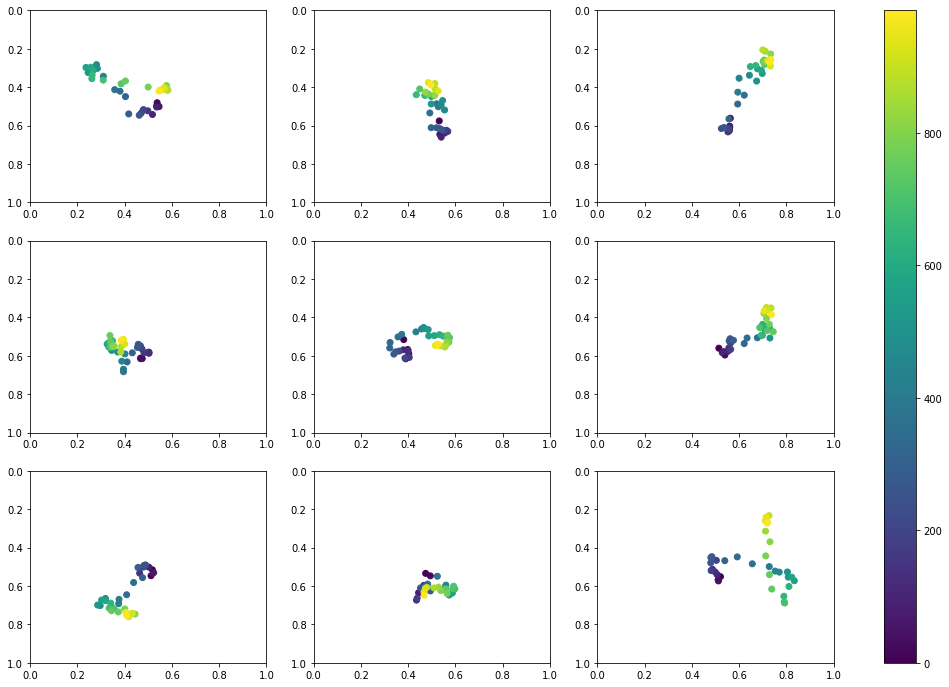

In [24]:
data_plot = add_var_to_data_et(data_et_fix, data_trial, 'chin')
data_plot = data_plot.loc[
    (data_plot['run_id']==43) & 
    (data_plot['chin']==0), :]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()
xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, 9):
    axes_data = data_plot.loc[(data_plot['x_pos']==xPos[i]) & (data_plot['y_pos']==yPos[i]), :]
    im = axes[i].scatter(
        axes_data['x'], 
        axes_data['y'], 
        c=axes_data['t_task'], 
        cmap='viridis'
    )
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
fig.colorbar(im, ax=axes)
plt.show()

## Heatmap

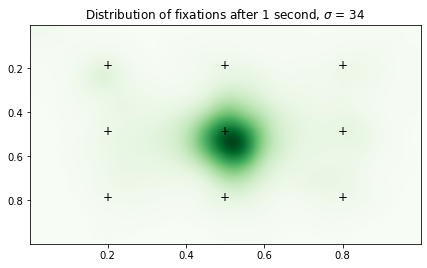

<Figure size 432x288 with 0 Axes>

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

x = data_et_fix['x']
y = data_et_fix['y']

def myplot(x, y, s, bins=[1200, 675]):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]
    return heatmap.T, extent

s=34
img, extent = myplot(x, y, s=s)

plt.figure(figsize=(7, 7))
plt.imshow(img, extent=extent, origin='upper', cmap=cm.Greens, aspect=(9/16))
plt.title("Distribution of fixations after 1 second, $\sigma$ = %d" % s)


xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, len(xPos)):
    plt.text(xPos[i], yPos[i], '+', size=12, ha="center")

plt.show()
plt.savefig('plots/fix_heatmap.png')

# Offset & precision

## Chin-rest conditions

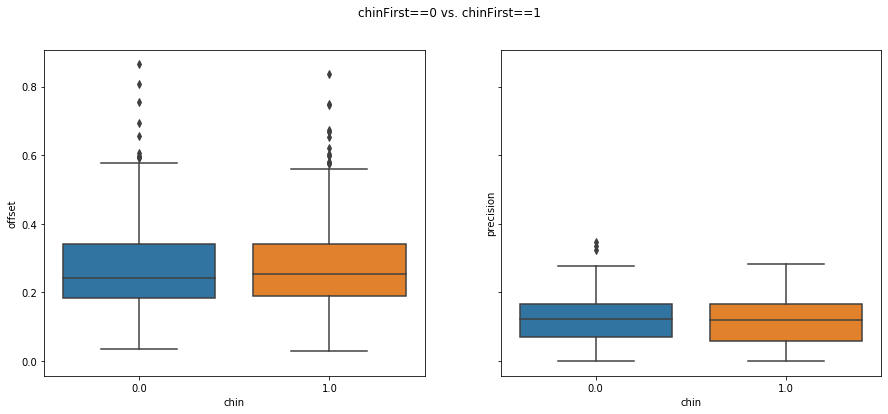

In [26]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', data=data_trial_fix)
sns.boxplot(ax=axes[1], x='chin', y='precision', data=data_trial_fix)
   
plt.show()

In [27]:
means_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].mean() \
    .reset_index() \
    .rename(columns={0: 'mean'})
var_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].var() \
    .reset_index() \
    .rename(columns={0: 'var'})
means_0.merge(var_0, on='index', how='left')

,index,mean,var
0,offset_chin_0,0.272910,0.006287
1,offset_chin_1,0.280409,0.008123
2,precision_chin_0,0.118312,0.002603
3,precision_chin_1,0.113457,0.002655


In [28]:
test_data = data_subject.loc[
    pd.notna(data_subject['offset_chin_0']) & 
    pd.notna(data_subject['offset_chin_1']), :]
scipy.stats.ttest_rel(test_data['offset_chin_0'], test_data['offset_chin_1'])

Ttest_relResult(statistic=-0.6301280674444427, pvalue=0.5317976788633753)

### ChinFirst

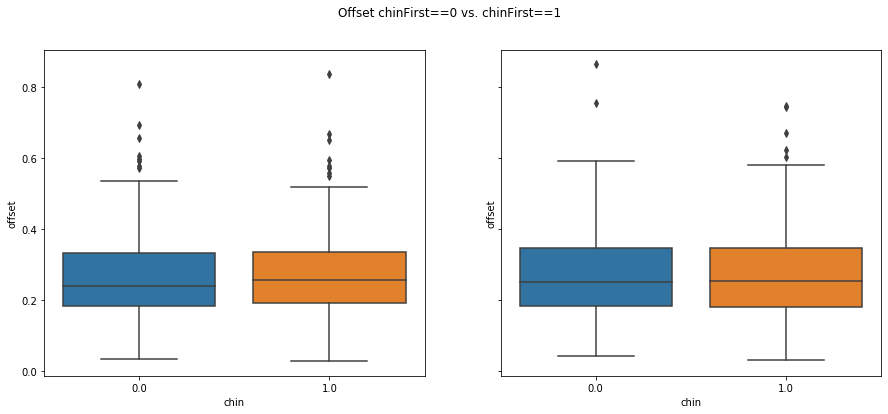

In [29]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

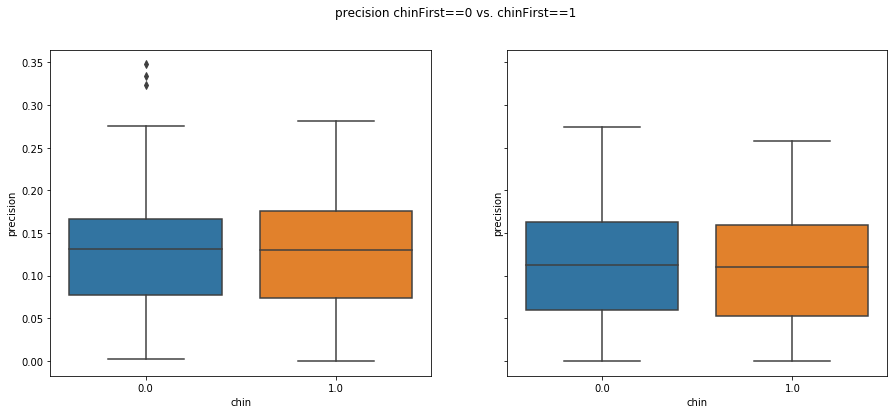

In [30]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

# Visual Aid

In [31]:
for col in ['glasses', 'sight']:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

col_0         count
glasses            
longSight         9
noCorrection     30
progressive       1
shortSight       17


col_0          count
sight               
contactLenses      5
glasses           21
notCorrected       1
perfectSight      30




In [32]:
data_subject['glasses_binary'] = data_subject['sight'] \
    .replace({'contactLenses': 1, 
             'glasses': 1,
             'notCorrected': 0,
             'perfectSight': 0}
           )
data_subject['glasses_binary'].unique()

array([ 1.,  0., nan])

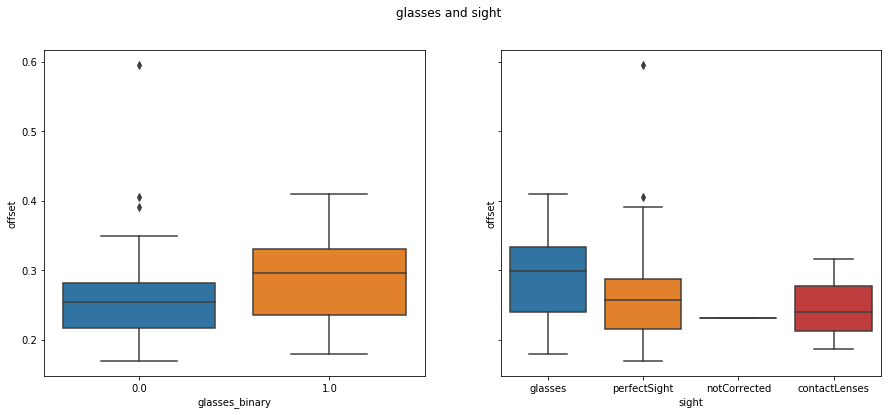

In [33]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('glasses and sight')

sns.boxplot(ax=axes[0], x='glasses_binary', y='offset', data=data_subject)
sns.boxplot(ax=axes[1], x='sight', y='offset', data=data_subject)
   
plt.show()

### Fixation dot positions

In [34]:
grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].var() \
    .rename(columns={'offset': 'offset_var', 'precision':'precision_var'}) \
    .reset_index()

grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].mean() \
    .reset_index()

grouped = grouped_means.merge(grouped_var, on=['positionIndex', 'chin'], how='left')

grouped_offset = grouped.loc[:, ['positionIndex', 'chin', 'offset']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_chin_0', 1.0: 'offset_chin_1'}) 

grouped_offset_var = grouped.loc[:, ['positionIndex', 'chin', 'offset_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset_var'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_var_chin_0', 1.0: 'offset_var_chin_1'}) 

grouped_precision = grouped.loc[:, ['positionIndex', 'chin', 'precision']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_chin_0', 1.0: 'precision_chin_1'}) 

grouped_precision_var = grouped.loc[:, ['positionIndex', 'chin', 'precision_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision_var'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_var_chin_0', 1.0: 'precision_var_chin_1'}) 

overview = pd.concat(
    [
        grouped_offset,
        grouped_offset_var.iloc[:, 1:3],
        grouped_precision.iloc[:, 1:3], 
        grouped_precision_var.iloc[:, 1:3]
    ], 
    axis=1
)

print(overview.mean(numeric_only=True))
overview

chin
positionIndex           4.000000
offset_chin_0           0.270804
offset_chin_1           0.273996
offset_var_chin_0       0.012012
offset_var_chin_1       0.013485
precision_chin_0        0.119066
precision_chin_1        0.116709
precision_var_chin_0    0.003803
precision_var_chin_1    0.003555
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


chin,positionIndex,offset_chin_0,offset_chin_1,offset_var_chin_0,offset_var_chin_1,precision_chin_0,precision_chin_1,precision_var_chin_0,precision_var_chin_1
0,0,0.346379,0.326973,0.012579,0.013547,0.149404,0.149478,0.005526,0.004774
1,1,0.271942,0.255620,0.011859,0.008346,0.107328,0.106158,0.003443,0.003821
2,2,0.359850,0.315976,0.019203,0.014458,0.151704,0.154726,0.006305,0.004400
3,3,0.252764,0.240945,0.007182,0.009048,0.116585,0.112112,0.003220,0.003099
4,4,0.125986,0.141202,0.009263,0.014959,0.057753,0.052454,0.001925,0.001919
5,5,0.227757,0.253451,0.009874,0.013054,0.117596,0.120706,0.003054,0.003019
6,6,0.329827,0.349272,0.010353,0.011451,0.134400,0.125766,0.004319,0.003174
7,7,0.232363,0.263370,0.019216,0.018331,0.103133,0.104291,0.002083,0.003707
8,8,0.290371,0.319152,0.008581,0.018170,0.133689,0.124694,0.004354,0.004077


## Calibration

In [35]:
data_et_calibration = data_et.loc[data_et['trial_type']=='eyetracking-calibration', :]
data_trial_calibration = data_trial.loc[data_trial['trial_type']=='eyetracking-calibration', :]

### offset

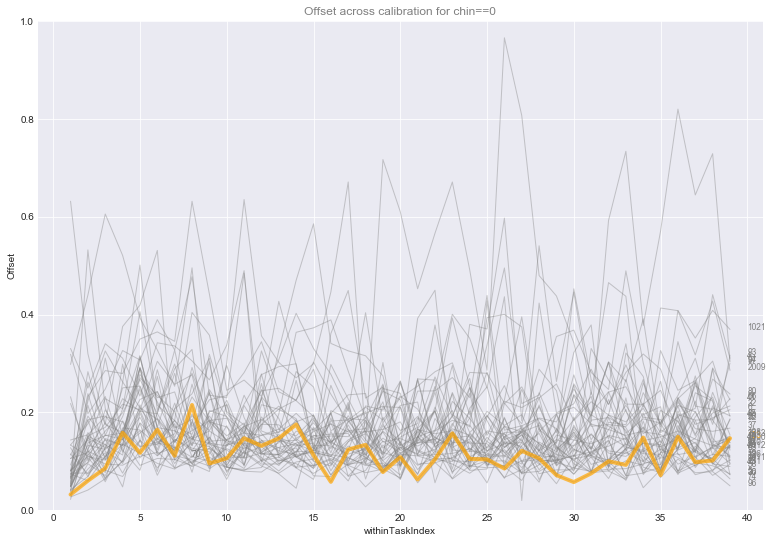

In [36]:
def spaghettiPlot(data, xVar, yVar, highlightedSubject):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(13, 9))

    # Draw Plots
    for subject in data["run_id"].unique():
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'offset', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

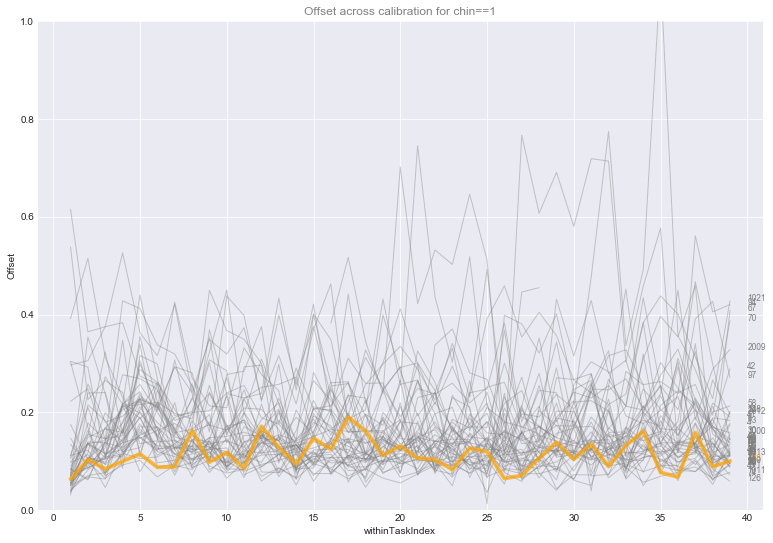

In [37]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'offset', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

### Precision

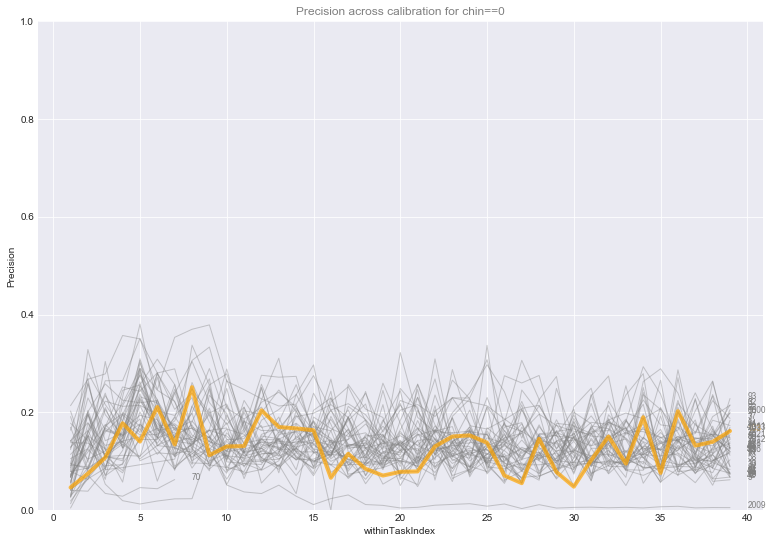

In [38]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

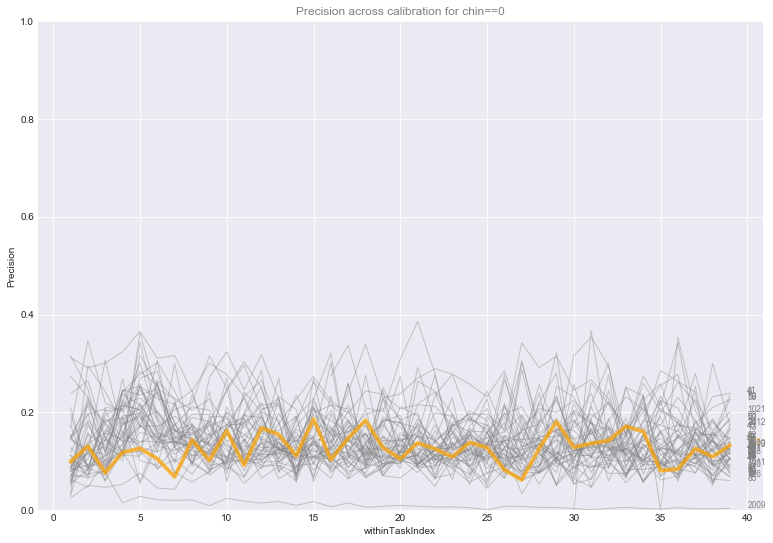

In [39]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

## categorical confounders

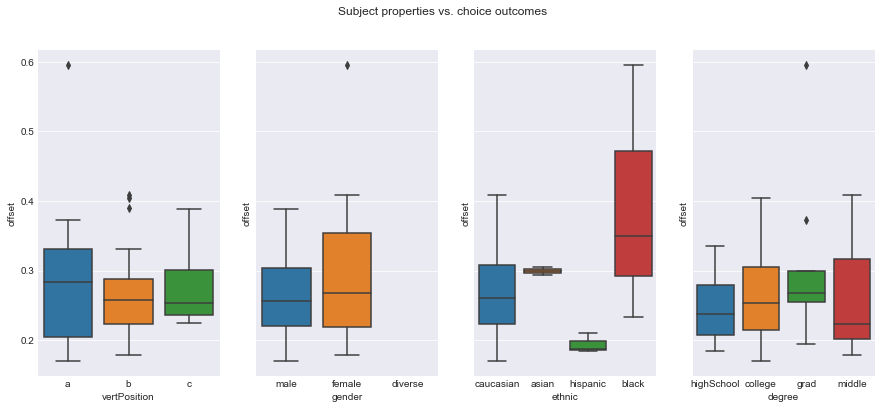

In [40]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(3*5, 6))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = [
    'vertPosition',
    'gender',
    'ethnic', 
    'degree'
             ]  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='offset', data=data_subject)

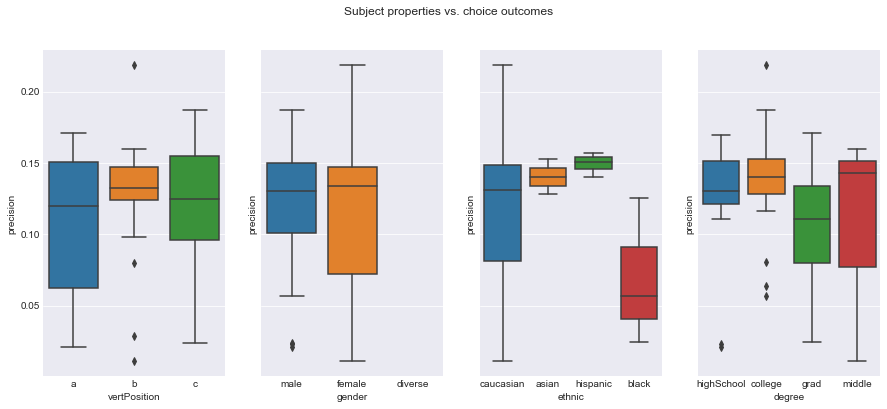

In [41]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(3*5, 6))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = [
    'vertPosition',
    'gender',
    'ethnic', 
    'degree'
             ]  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='precision', data=data_subject)

# Correlation Plot

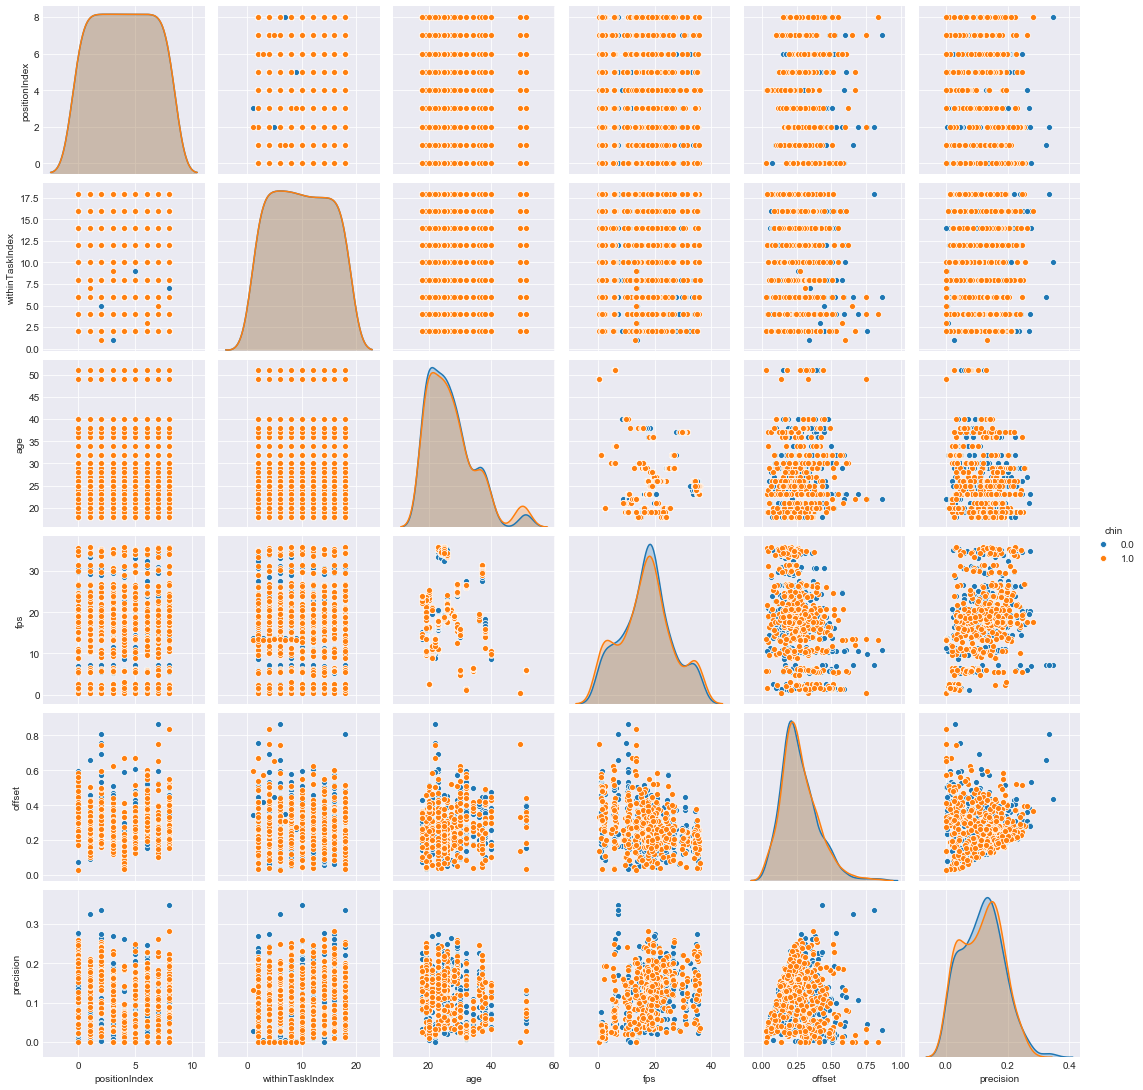

In [42]:
data_plot = data_trial_fix.merge(data_subject.loc[:, ['run_id', 'age']], on='run_id', how='left')
correlation_columns = ['positionIndex', 'withinTaskIndex', 'age', 'fps', 'offset', 'precision']
sns.pairplot(data_plot.loc[:, np.append(correlation_columns, ['chin'])], hue='chin')

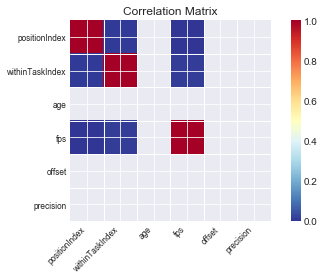

In [43]:
corr_matrix = np.corrcoef(data_plot[correlation_columns].T)
smg.plot_corr(corr_matrix, xnames=correlation_columns)
plt.show()

In [44]:
data_plot[correlation_columns].rcorr()

,positionIndex,withinTaskIndex,age,fps,offset,precision
positionIndex,-,,,,,*
withinTaskIndex,0.006,-,,,,*
age,-0.0,-0.0,-,***,*,***
fps,-0.003,0.01,-0.187,-,***,***
offset,-0.061,-0.067,0.088,-0.346,-,
precision,-0.087,0.079,-0.172,0.425,-0.03,-


In [45]:
data_plot[correlation_columns].rcorr(upper='n')

,positionIndex,withinTaskIndex,age,fps,offset,precision
positionIndex,-,837,711,837,822,822
withinTaskIndex,0.006,-,711,837,822,822
age,-0.0,-0.0,-,711,696,696
fps,-0.003,0.01,-0.187,-,822,822
offset,-0.061,-0.067,0.088,-0.346,-,822
precision,-0.087,0.079,-0.172,0.425,-0.03,-


# MLA Model

In [46]:
data_plot = data_trial_fix.loc[:, ['run_id', 'chin', 'x_pos', 'y_pos', 'precision']]
null_data = data_plot.loc[data_plot.isnull().any(axis=1), :]
data_plot = data_plot.loc[pd.notna(data_plot['precision']), :].reset_index(drop=True)
data_plot.loc[data_plot.isnull().any(axis=1), :]
model = smf.mixedlm("precision ~ x_pos", data_plot, groups=data_plot["run_id"])
model_fit = model.fit()
print(model_fit.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: precision
No. Observations: 822     Method:             REML     
No. Groups:       47      Scale:              0.0022   
Min. group size:  3       Log-Likelihood:     1265.9028
Max. group size:  18      Converged:          Yes      
Mean group size:  17.5                                 
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.113    0.008 14.129 0.000  0.098  0.129
x_pos         0.004    0.007  0.587 0.557 -0.009  0.017
Group Var     0.002    0.011                           



C:\Users\User\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# Export

In [47]:
data_et_calibration.to_csv("data_jupyter/data_et_calibration.csv", index=False, header=True)
data_trial_calibration.to_csv("data_jupyter/data_trial_calibration.csv", index=False, header=True)

data_et_fix.to_csv("data_jupyter/data_et_fix.csv", index=False, header=True)
data_trial_fix.to_csv("data_jupyter/data_trial_fix.csv", index=False, header=True)

data_subject.to_csv("data_jupyter/data_subject.csv", index=False, header=True)

# Feedback

In [48]:
print('Success! Script ran through')

Success! Script ran through
